In [1]:
# python modules
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, glob
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# specific modules:
sys.path.append("D:\GitHub\ProcessLidarSignal\_modules") # location of the modules
from __modules_generic import *

### Part I: grabbing all .nc files

In [19]:
# code to get file names and store them in list
from glob import glob

root_dir3 = 'D:\\Data_Kuliah\\SCC_output\\krakow_2022\\optical_products_compare16'
root_dir2 = 'D:\\Data_Kuliah\\Krakow_Smog_2022\\data_netCDF_SCC'
root_dir1 = 'D:\Data_Kuliah\\SCC_output\\krakow_2022'
root_vi_22 = 'D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022'

def getfilespath(root_dir='D:\Data_Kuliah\\SCC_output\\krakow_2022',file_extension ='*.nc'):
    # Get a list of all subdirectories in the root directory
    all_subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    # Create a list to store the path of all files with the '.txt' extension
    
    txt_files = glob(f"{root_dir}/{file_extension}")

    # Loop through all subdirectories
    for subdir in all_subdirectories:
        # Get the full path of the subdirectory
        subdir_path = os.path.join(root_dir, subdir)
        # Use glob to search for all files with the '.txt' extension in the subdirectory
        txt_files_in_subdir = glob(os.path.join(subdir_path, file_extension))
        # Add the found files to the list of all '.txt' files
        txt_files.extend(txt_files_in_subdir)
    print(f'total {file_extension} selected: {len(txt_files)}')
    return txt_files

# Print the list of all '.txt' files
# print(getfilespath(root_dir3))
files = getfilespath(root_vi_22,file_extension='*.nc')
# files
selec_param=[] #store string to be used as seletection parameters, ig: 20220603VI01
for file in files:
    selec_param.append(file[0][91:-15])

total *.nc selected: 90


In [3]:
# selec from file list
def filter_files(files_paths,search_string='mddhh'):
    '''
    param:
    files (list of string): containing the paths to files
    search_string(string):

    return:
    list of selected file paths based on the selection string criteria
    '''
    files_paths = [file for file in files if search_string in file]
    return files_paths
filter_files(files,'0603VI20')


['D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022\\rzc_000_1064_0001411_202206031959_202206032059_20220603VI20_elda_v5.2.5.nc',
 'D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022\\rzc_002_0355_0001416_202206031959_202206032059_20220603VI20_elda_v5.2.5.nc',
 'D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022\\rzc_002_0532_0001415_202206031959_202206032059_20220603VI20_elda_v5.2.5.nc',
 'D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022\\rzc_007_0355_0001405_202206031959_202206032059_20220603VI20_elda_v5.2.5.nc',
 'D:\\Data_Kuliah\\Data_SCC_output\\vilnius_2022\\rzc_007_0532_0001406_202206031959_202206032059_20220603VI20_elda_v5.2.5.nc']

In [21]:
def define_ds(filespath,select='16ts00',dateselect=None):# Open the netCDF file
    '''
    Parameters:
    filespath (list):
    select (string): string line to be used as filter to select specific data product (ig., 220604VI23 - indicator for data 2022 June 05 Vilnius hour 23)
                     or exact time: 2206042358
    
    Return:
    xarray
    '''
    # sel_file = file_list2[2]
    # ds = xr.open_dataset(f"{sel_file}")
    # ds
    numfiles=0
    for scc_product in filespath:        
        if select in scc_product:
            if dateselect==None:
                if '000_1064' in scc_product:
                    ds_1064 = xr.open_dataset(f"{scc_product}")
                    numfiles+=1
                elif '002_0532' in scc_product:
                    ds_532_2 = xr.open_dataset(f"{scc_product}")
                    numfiles+=1
                elif '007_0532' in scc_product:
                    ds_532_7 = xr.open_dataset(f"{scc_product}")
                    numfiles+=1
                elif '002_0355' in scc_product:
                    ds_355_2 = xr.open_dataset(f"{scc_product}")
                    numfiles+=1
                elif '007_0355' in scc_product:
                    ds_355_7 = xr.open_dataset(f"{scc_product}")
                    numfiles+=1
                else: print('no optical product found!')
            elif dateselect!=None:
                if dateselect in scc_product:
                    if '000_1064' in scc_product:
                        ds_1064 = xr.open_dataset(f"{scc_product}")
                        numfiles+=1
                    elif '002_0532' in scc_product:
                        ds_532_2 = xr.open_dataset(f"{scc_product}")
                        numfiles+=1
                    elif '007_0532' in scc_product:
                        ds_532_7 = xr.open_dataset(f"{scc_product}")
                        numfiles+=1
                    elif '002_0355' in scc_product:
                        ds_355_2 = xr.open_dataset(f"{scc_product}")
                        numfiles+=1
                    elif '007_0355' in scc_product:
                        ds_355_7 = xr.open_dataset(f"{scc_product}")
                        numfiles+=1
                    else: print('no optical product found!')
    if numfiles!=0: print (f'{numfiles} files detected for {select}!')
    elif numfiles==0: print(f'selected file type {select} is not found in {filespath}')
    return ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7
# ds_1064,ds_532_2,ds_532_7= define_ds(getfilespath(root_dir2),select='smog_episodes',dateselect='20220119tst0001')
# ds_1064,ds_532_2,ds_532_7= define_ds(getfilespath(),select='16ts01')
# ds_1064_obi,ds_532_2_obi,ds_532_7_obi= define_ds(getfilespath()[3:7])

ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7= define_ds(filespath=files,select='220605VI20')

5 files detected for 220605VI20!


5 files detected for 0603VI20!
no extinciton product for this channel
no extinciton product for this channel
no extinciton product for this channel


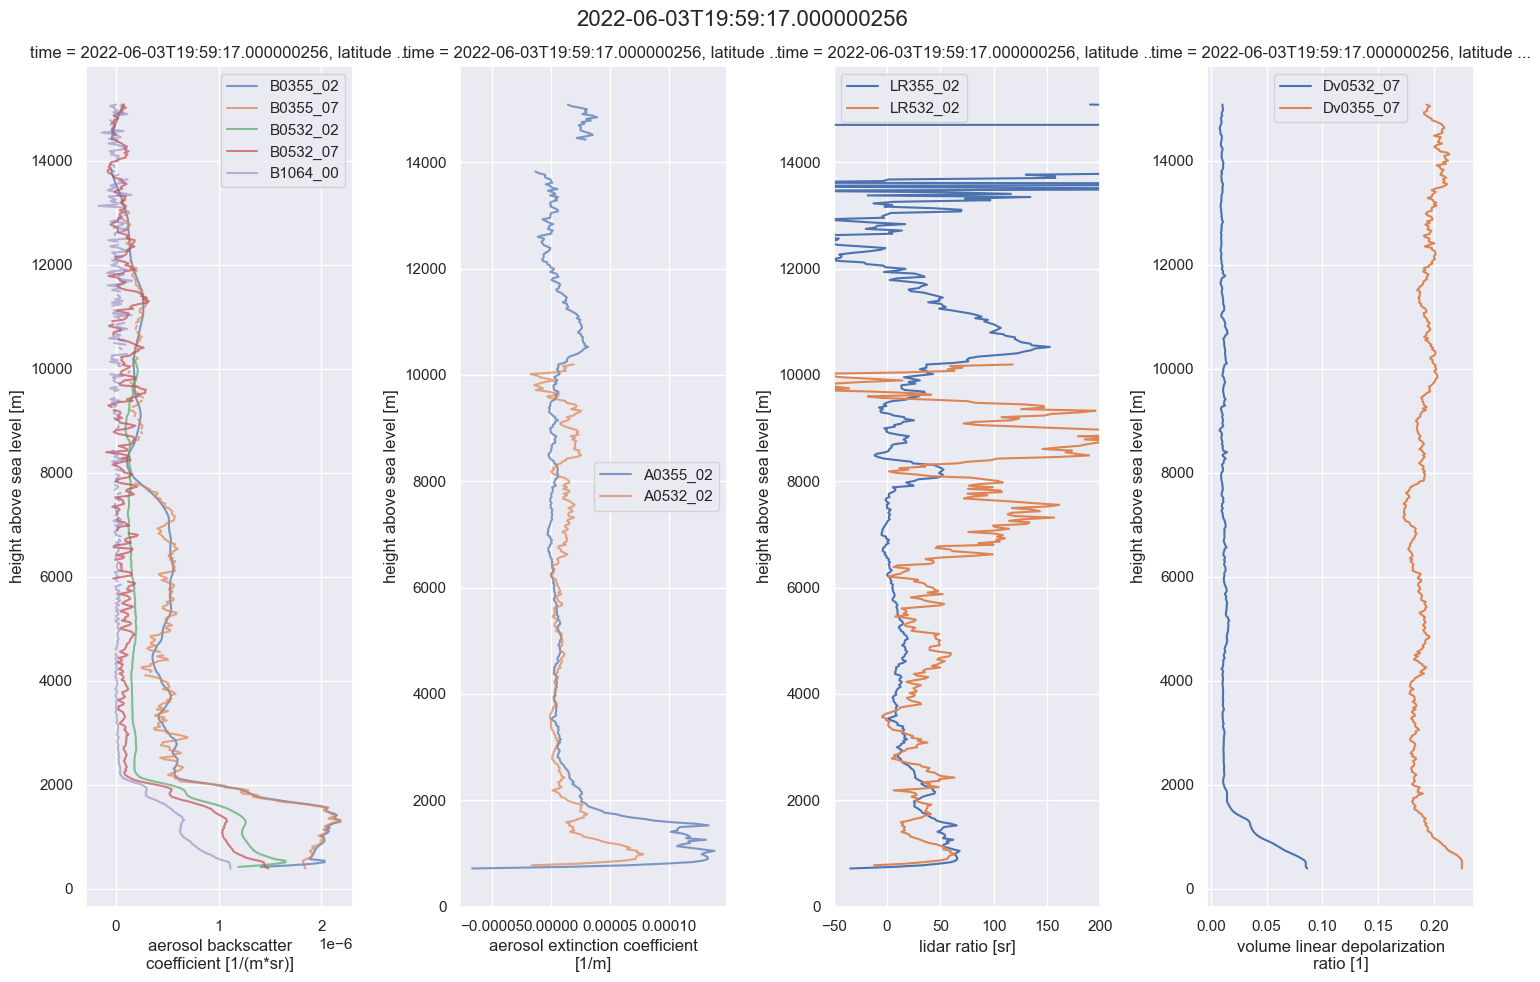

In [23]:

# plotting optical products
def plot_optical_properties(ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7,save_option=None,path_out='D:\\',filename='Write file name'):
    sns.set()
    # plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(ncols=4,figsize=(15,10))
    # fig.set_figure(10,15)

    # LR_532_7 = ds_532_7['extinction']/ds_532_7['backscatter']
    # LR_532_7.plot(ax=axs[1],y='altitude',label='LR532_07')

    #backscatter coeff
    ds_355_2['backscatter'].plot(ax=axs[0],y='altitude',label='B0355_02',marker="",alpha=0.7)
    ds_355_7['backscatter'].plot(ax=axs[0],y='altitude',label='B0355_07',marker="",alpha=0.7)
    ds_532_2['backscatter'].plot(ax=axs[0],y='altitude',label='B0532_02',marker="",alpha=0.7)
    ds_532_7['backscatter'].plot(ax=axs[0],y='altitude',label='B0532_07',marker="",alpha=0.7)
    ds_1064['backscatter'].plot(ax=axs[0],y='altitude',label='B1064_00',marker="",alpha=0.5)
    

    #extinction coeff
    try: ds_355_2['extinction'].plot(ax=axs[1],y='altitude',label='A0355_02',marker="",alpha=0.7)
    except: print('no extinciton product for this channel')
    try: ds_355_7['extinction'].plot(ax=axs[1],y='altitude',label='A0355_07',marker="")
    except: print('no extinciton product for this channel')
    try: ds_532_2['extinction'].plot(ax=axs[1],y='altitude',label='A0532_02',marker="",alpha=0.7)
    except: print('no extinciton product for this channel')
    try: ds_532_7['extinction'].plot(ax=axs[1],y='altitude',label='A0532_07',marker="")
    except: print('no extinciton product for this channel')
    try: ds_1064['extinction'].plot(ax=axs[1],y='altitude',label='A1064_00',marker="",alpha=0.5)
    except: print('no extinciton product for this channel')
    

    #lidar ratio
    LR_355_2 = ds_355_2['extinction']/ds_355_2['backscatter']
    LR_355_2.plot(ax=axs[2],y='altitude',label='LR355_02')
    LR_532_2 = ds_532_2['extinction']/ds_532_2['backscatter']
    LR_532_2.plot(ax=axs[2],y='altitude',label='LR532_02')
    axs[2].set_xlabel('lidar ratio [sr]')
    axs[2].set_xlim(-50,200)

    # depolarization ratio
    axs[3].set_title('depolarization ratio')
    ds_532_7['volumedepolarization'].plot(ax=axs[3],y='altitude',label='Dv0532_07',marker="")
    ds_355_7['volumedepolarization'].plot(ax=axs[3],y='altitude',label='Dv0355_07',marker="")
    # ds_532_7['error_volumedepolarization'].plot(ax=axs[3],y='altitude',label='error',marker="")
    # ds_532_7['particledepolarization'].plot(ax=axs[3],y='altitude',label='Dp0532_07',marker=".")

    # fig.title('Time=01:00-01:30')
    # axs[0].set_title('backscatter coefficients')
    # axs[1].set_title('extinction coefficients')
    # axs[2].set_title('lidar ratio')
    # axs[3].set_title('depolarization ratio')
    for ax in axs:
        # ax.set_ylim(0,5000)
        ax.legend()
        # ax.set_label()
    # fig.set
    date = ds_1064['time'].values[0]
    fig.suptitle(f'{date}', fontsize=16)

    plt.tight_layout()
    plt.draw()
    if save_option!=None: plt.savefig(f'{path_out}\{filename}.png', bbox_inches='tight')
ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7= define_ds(filespath=files,select='0603VI20')    
plot_optical_properties(ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7)

### Part II: further preocess
extraprolate first, to get the backscatter, extintion, and other values to the ground level (surface)
Note: needed to be converted to data frame (because its still difficult for me to handle xarray data, expecially to plot errors and do math)

In [30]:
ds_532_7

<xarray.Dataset>
Dimensions:                                         (altitude: 491, time: 1,
                                                     nv: 2, wavelength: 1)
Coordinates:
  * altitude                                        (altitude) float64 386.0 ...
  * time                                            (time) datetime64[ns] 202...
    latitude                                        float32 ...
    longitude                                       float32 ...
  * wavelength                                      (wavelength) float32 532.0
Dimensions without coordinates: nv
Data variables: (12/25)
    time_bounds                                     (time, nv) datetime64[ns] ...
    vertical_resolution                             (wavelength, time, altitude) float64 ...
    cirrus_contamination                            float32 ...
    cloud_mask_type                                 float32 ...
    error_retrieval_method                          (wavelength) float32 ...
    scc_product_type                                float32 ...
    ...                                              ...
    backscatter_calibration_range_search_algorithm  (wavelength) float32 ...
    backscatter_calibration_range                   (wavelength, nv) float32 ...
    volumedepolarization                            (wavelength, time, altitude) float64 ...
    error_volumedepolarization                      (wavelength, time, altitude) float64 ...
    particledepolarization                          (wavelength, time, altitude) float64 ...
    error_particledepolarization                    (wavelength, time, altitude) float64 ...
Attributes: (12/33)
    measurement_ID:                       20220603VI20
    system:                               ESA MObile RAman Lidar
    institution:                          University of Warsaw/Poznan Univers...
    location:                             Rzecin, Poland
    station_ID:                           rzc
    PI:                                   Iwona S. Stachlewska
    ...                                   ...
    Conventions:                          CF-1.7
    hoi_system_ID:                        127
    hoi_configuration_ID:                 681
    input_file:                           rzc_007_0001406_202206031959_202206...
    measurement_start_datetime:           2022-06-03T19:59:17Z
    measurement_stop_datetime:            2022-06-03T20:59:53Z

In [6]:
def _todataframe(ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7):
    '''
    conver xarray to dataframes
    param:
    ds (xarray)

    return
    dataframes
    '''
    df_1064=ds_1064.to_dataframe()
    df_1064=df_1064.reset_index()

    df_542_2=ds_532_2.to_dataframe()
    df_542_2=df_542_2.reset_index()

    df_532_7=ds_532_7.to_dataframe()
    df_532_7=df_532_7.reset_index()

    df_355_2=ds_355_2.to_dataframe()
    df_355_2=df_355_2.reset_index()

    df_355_7=ds_355_7.to_dataframe()
    df_355_7=df_355_7.reset_index()
    return df_1064,df_542_2,df_532_7,df_355_2,df_355_7

df_1064,df_532_2,df_532_7,df_355_2,df_355_7=_todataframe(ds_1064,ds_532_2,ds_532_7,ds_355_2,ds_355_7)
df_list = [df_1064,df_532_2,df_532_7,df_355_2,df_355_7]
# df_list


In [7]:
'''#
These methos should be applicable to fill in nan data in the middle of data framews
def fill_nan_dataframe(df,var='backscatter',method='poli'):
        
        function:
        fill in nan values in the data frame by mean of interpolation (several method included in this fucntion)
        params: 
        df (dataframe): dataframe that the nan values to be replace by interpolation

        return
        updated dataframe
        
        # python modules
        import numpy as np
        import pandas as pd
        import scipy.interpolate as spi
        
        #Linear Interpolation ---> need to be corrected, no .intergrate module fo data frame
        if method=='linear':                   
                df[var] = df[var].interpolate()

        x = df['altitude'].values
        y = df[var].values

        #Polinomial INterpolation
        if method=='poli':       
                interpolation_function = spi.interp1d(x, y, kind='polynomial', fill_value="extrapolate")
                df[var] = interpolation_function(x)


        #Spline Interpolation: This method uses spline functions to fill in missing values.
        if method=='spline':
                interpolation_function = spi.InterpolatedUnivariateSpline(x, y)
                df[var] = interpolation_function(x)

        return df
fill_nan_dataframe(df_355_2,var='backscatter',method='linear')
'''

'#\nThese methos should be applicable to fill in nan data in the middle of data framews\ndef fill_nan_dataframe(df,var=\'backscatter\',method=\'poli\'):\n        \n        function:\n        fill in nan values in the data frame by mean of interpolation (several method included in this fucntion)\n        params: \n        df (dataframe): dataframe that the nan values to be replace by interpolation\n\n        return\n        updated dataframe\n        \n        # python modules\n        import numpy as np\n        import pandas as pd\n        import scipy.interpolate as spi\n        \n        #Linear Interpolation ---> need to be corrected, no .intergrate module fo data frame\n        if method==\'linear\':                   \n                df[var] = df[var].interpolate()\n\n        x = df[\'altitude\'].values\n        y = df[var].values\n\n        #Polinomial INterpolation\n        if method==\'poli\':       \n                interpolation_function = spi.interp1d(x, y, kind=\'polynomi

In [8]:
#fill nan with values using interpoaltion
def fill_nan_dataframe(df):
    for var in df.columns:
        try: df[var]=df[var].interpolate()
        except Exception as e: print(f'{var}: {e}')
    return df

df_1064=fill_nan_dataframe(df_1064)
df_532_7=fill_nan_dataframe(df_532_7)
df_532_2=fill_nan_dataframe(df_532_2)
df_355_7=fill_nan_dataframe(df_355_7)
df_355_2=fill_nan_dataframe(df_355_2)
# df_updated_list

time: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time_bounds: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time_bounds: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time_bounds: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time_bounds: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear
time_bounds: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear


In [9]:
# add row on top to place the extrapoalaion value
def add_row(df):
    '''
    Function:
    add nan values at the first row of gios data:

    Parameters:
    df (data frame): input data frame to be added nan valued row

    return:
    modified data frame with nan valued row

    note:
    created for gios data (bosth PM2.5 and SO2) because the difference of start of measurement time.
    in gios it the hour started at 01:00 but in meteo it started at 00:00 but both end at 23:00.
    this fuction change the index of gios data to make propert merge later between gios and meteo data
    '''
    min_altitude=min(df_1064['altitude'])
    filler_altitude = np.linspace(0,min_altitude)
    filler_df=pd.DataFrame(columns=df_1064.columns)
    filler_df=filler_df.assign(altitude=filler_altitude)
    # filler_df
    df = df.reset_index(drop=True)
    result = pd.concat([filler_df, df], axis=0)
    result = result.reset_index()
    return result
# df_sample = add_row(df_355_2)
df_1064_updated=add_row(df_1064)
df_532_7_updated=add_row(df_532_7)
df_532_2_updated=add_row(df_532_2)
df_355_7_updated=add_row(df_355_7)
df_355_2_updated=add_row(df_355_2)
df_updated_list=[df_1064_updated,df_532_7_updated,df_532_2_updated,df_355_7_updated,df_355_2_updated]

### calculating AOD

### Part: Extrapolation 
Note: Skip for now:
step:
before using the method below, data nan (in the middle, not the one to be extrapolate on altitude to 0) should be filled first
This interpolation should be done before adding the rows to data frame
find a way to do that first, previous method searched on google (chatgpt can be used), the one that presiously error because x-axis must be increasing
This happened before because were trying to interpolate to zero

In [10]:
"""import numpy as np
from scipy import interpolate

# create sample data
x = df_355_2['altitude']
y = df_355_2['backscatter']

# create a linear interpolation function
f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

# extrapolate y for x values less than 5
min_altitude=min(df_355_2['altitude'])
x_extrap = np.linspace(0,min_altitude,100)
y_extrap = f(x_extrap)

print(y_extrap)"""

"import numpy as np\nfrom scipy import interpolate\n\n# create sample data\nx = df_355_2['altitude']\ny = df_355_2['backscatter']\n\n# create a linear interpolation function\nf = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')\n\n# extrapolate y for x values less than 5\nmin_altitude=min(df_355_2['altitude'])\nx_extrap = np.linspace(0,min_altitude,100)\ny_extrap = f(x_extrap)\n\nprint(y_extrap)"

In [11]:
def extrapoalte_poli(df,var='backscatter',deg=7):
    '''
    return
    extrapolated pd series
    '''
    import numpy as np
    from scipy import interpolate

    # create sample data
    x = df['altitude']
    y = df[var]

    # create a polynomial interpolation function
    p = np.polyfit(x, y, deg)
    f = np.poly1d(p)

    # extrapolate y for x values less than 5
    min_altitude=min(x)
    x_extrap = pd.Series(np.linspace(0,min_altitude))
    y_extrap = pd.Series(f(x_extrap))

    ycombined= pd.concat([y_extrap, y])
    xcombined= pd.concat([x_extrap, x])
    return ycombined,xcombined
# for i in range (0,100):
#     try:
#         extrapoalte_poli(df_355_2,'extinction',deg=i)
#         print ('sukse')
#     except Exception as e: print(e)

In [13]:
def extrapoalte_spline(df,var='backscatter'):
    '''
    func:
    extrapolate data to certain range outside of the domain

    param:

    return"
    
    '''
    import numpy as np
    from scipy import interpolate

    # create sample data
    x = df['altitude']
    y = df[var]

    # create a spline interpolation function
    f = interpolate.UnivariateSpline(x, y, k=5, s=4)

    # extrapolate y for x values less than 5
    min_altitude=min(x)
    x_extrap = pd.Series(np.linspace(0,min_altitude))
    y_extrap = pd.Series(f(x_extrap))

    ycombined= pd.concat([y_extrap, y])
    xcombined= pd.concat([x_extrap, x])
    # print(y_extrap)
    plt.plot(ycombined,xcombined,label=f'{var}')
# extrapoalte_spline(df_532_2,var='extinction')


no extinction
no extinction
no extinction
no extinction
no extinction
no volumedepolarization
no volumedepolarization
no volumedepolarization
no volumedepolarization
no volumedepolarization


<function matplotlib.pyplot.cla()>

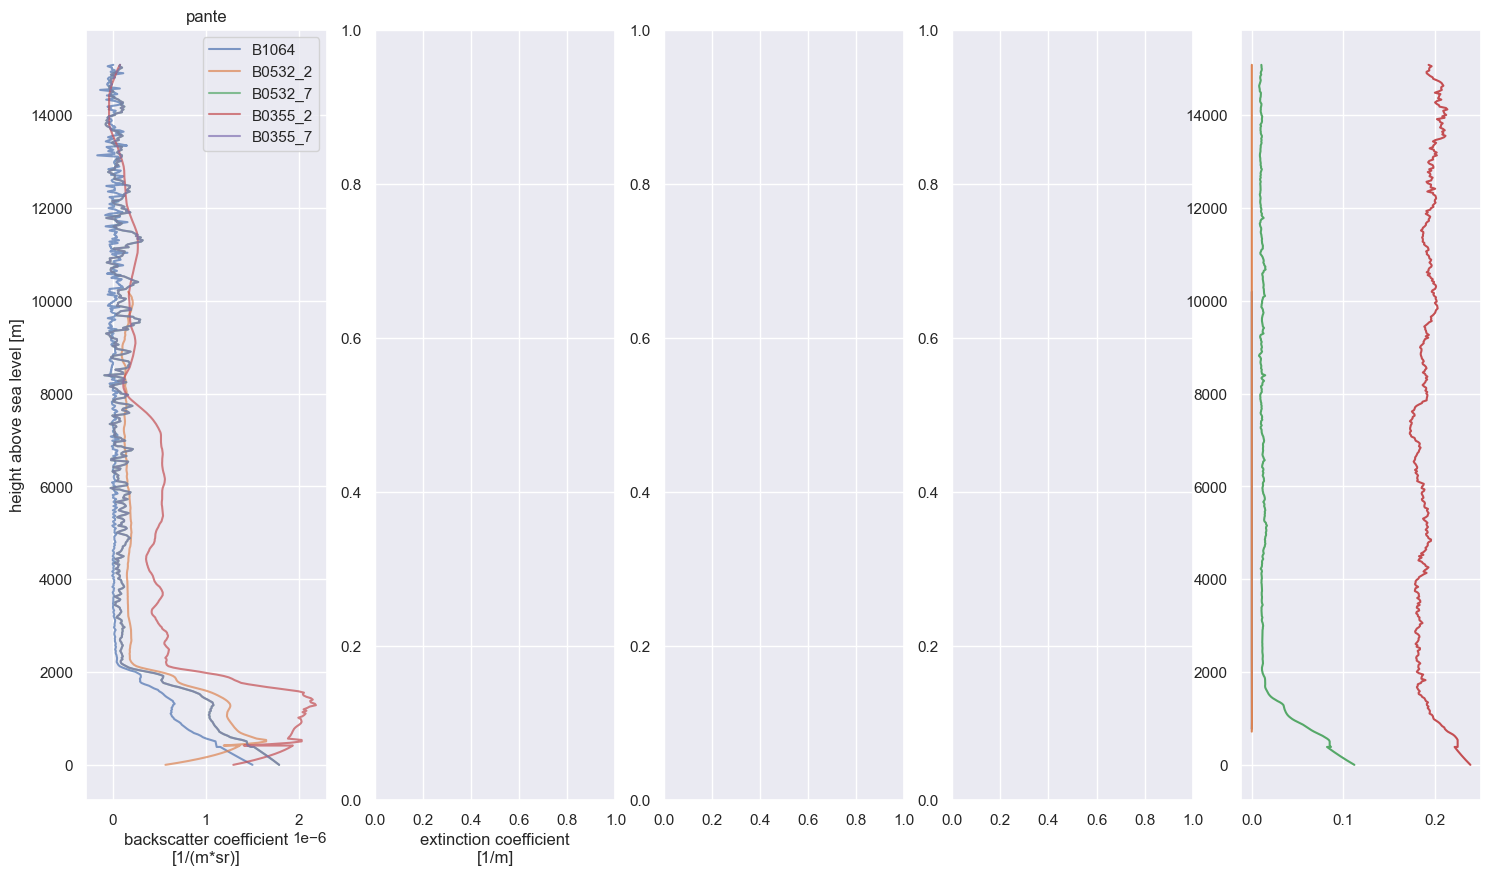

In [34]:
# plotting
sns.set()
# plt.figure(figsize=(20,15))
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(18,10))
# fig.set_figure(10,15)

# LR_532_7 = ds_532_7['extinction']/ds_532_7['backscatter']
# LR_532_7.plot(ax=axs[1],y='altitude',label='LR532_07')

#backscatter coeff
_1064=extrapoalte_poli(df_1064,'backscatter')
ax1.plot(_1064[0],_1064[1],label='B1064',marker="",alpha=0.7)
_0532_2=extrapoalte_poli(df_532_2,'backscatter')
ax1.plot(_0532_2[0],_0532_2[1],label='B0532_2',marker="",alpha=0.7)
_0532_7=extrapoalte_poli(df_532_7,'backscatter')
ax1.plot(_0532_7[0],_0532_7[1],label='B0532_7',marker="",alpha=0.7)
_0355_2=extrapoalte_poli(df_355_2,'backscatter')
ax1.plot(_0355_2[0],_0355_2[1],label='B0355_2',marker="",alpha=0.7)
_0355_7=extrapoalte_poli(df_532_7,'backscatter')
ax1.plot(_0355_7[0],_0355_7[1],label='B0355_7',marker="",alpha=0.7)
ax1.set_title('pante')

#exctintion coeff
try:
    _1064=extrapoalte_spline(df_1064,var='extinction')
    ax2.plot(_1064[0],_1064[1],label='A1064',marker="",alpha=0.7)
except: print('no extinction')
try:
    _0532_2=extrapoalte_spline(df_532_2,var='extinction')
    ax2.plot(_0532_2[0],_0532_2[1],label='A0532_2',marker="",alpha=0.7)
except: print('no extinction')
try:
    _0532_7=extrapoalte_spline(df_532_7,var='extinction')
    ax2.plot(_0532_7[0],_0532_7[1],label='A0532_7',marker="",alpha=0.7)
except: print('no extinction')
try:
    _0355_2=extrapoalte_spline(df_355_2,var='extinction')
    ax2.plot(_0355_2[0],_0355_2[1],label='A0355_2',marker="",alpha=0.7)
except: print('no extinction')
try:
    _0355_7=extrapoalte_spline(df_355_7,var='extinction')
    ax2.plot(_0355_7[0],_0355_7[1],label='A0355_7',marker="",alpha=0.7)
except: print('no extinction')


#vOlume depo ratio
try:
    _1064=extrapoalte_spline(df_1064,var='volumedepolarization')
    ax3.plot(_1064[0],_1064[1],label='Dv1064',marker="",alpha=0.7)
except: print('no volumedepolarization')
try:
    _0532_2=extrapoalte_spline(df_532_2,var='volumedepolarization')
    ax3.plot(_0532_2[0],_0532_2[1],label='Dv0532_2',marker="",alpha=0.7)
except: print('no volumedepolarization')
try:
    _0532_7=extrapoalte_spline(df_532_7,var='volumedepolarization')
    ax3.plot(_0532_7[0],_0532_7[1],label='Dv0532_7',marker="",alpha=0.7)
except: print('no volumedepolarization')
try:
    _0355_2=extrapoalte_spline(df_355_2,var='volumedepolarization')
    ax3.plot(_0355_2[0],_0355_2[1],label='Dv0355_2',marker="",alpha=0.7)
except: print('no volumedepolarization')
try:
    _0355_7=extrapoalte_spline(df_355_7,var='volumedepolarization')
    ax3.plot(_0355_7[0],_0355_7[1],label='Dv0355_7',marker="",alpha=0.7)
except: print('no volumedepolarization')


# depolarization ratio
# volumedepolarization

ax1.set_ylabel('height above sea level [m]')
ax1.set_xlabel('backscatter coefficient\n[1/(m*sr)]')
ax2.set_xlabel('extinction coefficient\n[1/m]')
ax1.legend()



plt.draw()
plt.cla

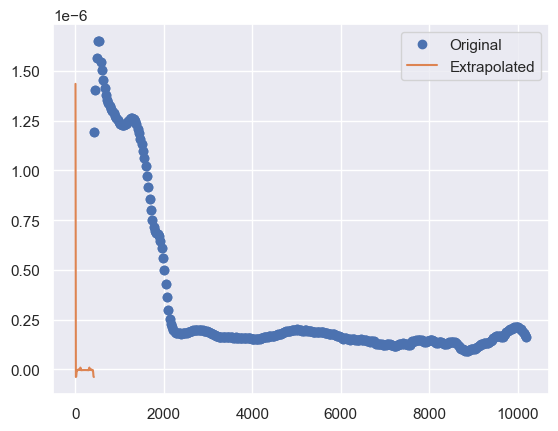

In [ ]:
# Fourier 
def extrapoalte_fourier(df,var='backscatter'):
    import numpy as np
    from scipy import fftpack

    

    import numpy as np
    import pandas as pd
    from scipy.interpolate import InterpolatedUnivariateSpline

    # create sample data
    x = df['altitude']
    y = df[var]
    # define the extrapolation range for x-values
    min_altitude=min(x)
    x_extrapolate = pd.Series(np.linspace(0,min_altitude))

    # perform Fourier extrapolation
    n = len(x)
    fourier_coeffs = np.fft.fft(y) / n
    freqs = np.fft.fftfreq(n, d=x.diff().mean())
    freqs = 2*np.pi*freqs
    n_extrapolate = len(x_extrapolate)
    extrapolated_coeffs = np.zeros(n_extrapolate, dtype=np.complex_)
    for i in range(n_extrapolate):
        for j in range(n):
            extrapolated_coeffs[i] += fourier_coeffs[j] * np.exp(1j*freqs[j]*x_extrapolate[i])
    extrapolated_y = np.real(np.fft.ifft(extrapolated_coeffs))

    # create a new Series with extrapolated x and y values
    extrapolated = pd.Series(extrapolated_y, index=x_extrapolate)

    # plot the original and extrapolated data
    import matplotlib.pyplot as plt
    plt.plot(x, y, 'o', label='Original')
    plt.plot(extrapolated.index, extrapolated, label='Extrapolated')
    plt.legend()
    plt.show()

extrapoalte_fourier(df_532_2)


C:\Users\Com\AppData\Local\Temp\ipykernel_6948\3787436391.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  model.fit(x[:, np.newaxis], y)


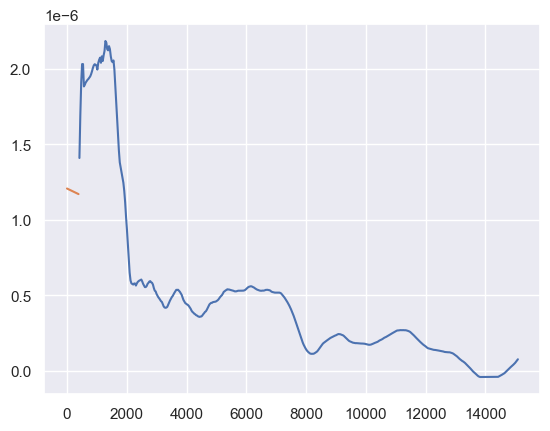

In [ ]:
# draft function for extrapolation on altitude to zero

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

############# linear regression
# Generate some example data
x = df_355_2['altitude']
y = df_355_2['backscatter']

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(x[:, np.newaxis], y)

min_altitude=min(df_1064['altitude'])
filler_altitude = np.linspace(0,min_altitude)

# Predict the values of y when x is close to zero
x_pred = filler_altitude[:, np.newaxis]
y_pred = model.predict(x_pred)

# Plot the original data and the extrapolated values
plt.plot(x, y, '-')
plt.plot(x_pred, y_pred, '-')
plt.show()



In [ ]:
########## Polinomial Regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Generate sample data
x = df_355_2['altitude']
y = df_355_2['backscatter']

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(x.reshape(-1, 1))

# Fit a polynomial regression model
reg = LinearRegression().fit(X, y)

# Predict values for extrapolation
x_extrapolate = np.linspace(-10, 20, 50)
X_extrapolate = poly.fit_transform(x_extrapolate.reshape(-1, 1))
y_extrapolate = reg.predict(X_extrapolate)

# Plot the results
plt.scatter(x, y, label='Original Data')
plt.plot(x_extrapolate, y_extrapolate, label='Polynomial Regression')
plt.legend()
plt.show()

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
########## Spline regression
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Generate sample data
x = np.linspace(0, 10, 20)
y = 3 * x**2 + 2 * x + 1 + np.random.normal(0, 10, len(x))

# Fit a spline regression model
spline = UnivariateSpline(x, y, s=1)

# Predict values for extrapolation
x_extrapolate = np.linspace(-10, 20, 50)
y_extrapolate = spline(x_extrapolate)

# Plot the results
plt.scatter(x, y, label='Original Data')
plt.plot(x_extrapolate, y_extrapolate, label='Spline Regression')
plt.legend()
plt.show()

########### Fourier Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# Generate sample data
x = np.linspace(0, 10, 20)
y = 3 * np.sin(2 * np.pi * x) + 2 * x + 1 + np.random.normal(0, 10, len(x))

# Compute the Fourier transform of the data
y_fourier = fft(y)

# Predict values for extrapolation
x_extrapolate = np.linspace(-10, 20, 50)
y_extrapolate = np.zeros(len(x_extrapolate))
# for i in range(len(y_fourier) // 2):
#     y_extrapolate += 2 * y_fourier[i] * np.cos(2 * np.pi *)


In [ ]:
'''## update nan values
import numpy as np
import pandas as pd
from fancyimpute import KNN

# create a sample DataFrame with NaN values
# df = pd.DataFrame({
#     "A": [1, 2, np.nan, 4],
#     "B": [5, np.nan, 7, 8]
# })

# fill NaN values with the KNN imputation method
def fillna_(df,method='knn',k=1000):
    # df = df.to_dataframe()
    if method=='knn':
        imputer = KNN(k)
        df_imputed = imputer.fit_transform(df)
        df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
    elif method=='linear_inter':
        df_imputed = df.interpolate(method='linear', inplace=True)
    elif method=='linear':
        df_imputed = df.interpolate(method='linear', limit_direction='forward', inplace=True)
    else: print('wrong method input!')

    return df_imputed


import pandas as pd
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

def extrapolate_nan(series):
    x = series.dropna().index
    y = series.dropna().values
    spl = InterpolatedUnivariateSpline(x, y)
    index = series.index
    values = spl(index)
    return pd.Series(values, index=index)

ext_val_532_ex= extrapolate_nan(pd.Series(ext_val_532))
plt.plot(ext_val_532_ex,alt_val)
plt
# data = df_sample['backscatter']
# extrapolated_data = data.apply(extrapolate_nan)
# print(extrapolated_data)



# df_542_2_updated=fillna_(df_sample['backscatter'],method='knn')
# df_542_2_updated
# plt.figure(figsize=(5,10))
# plt.plot(df_542_2_updated)
# # plt.plot(df_542_2_updated['backscatter'],df_542_2_updated['altitide'],xerr=ext_err,ecolor='red')
# plt.ylim(0,2000)
# for i in range(100,10000,500):
#     df_542_2_updated=fillna_(df_sample,method='knn',k=i)

# # ext_val = df_542_2_updated['extinction'].values
# # ext_err = df_542_2_updated['error_extinction'].values
# # alt_par = df_alt['altitude'].values
# # alt_val = np.linspace(0,max(alt_par),num=len(ext_val))
# # # print(f'{len(s)} and {len(b)}')
# # plt.figure(figsize=(5,15))
# plt.plot(ext_val,alt_val,xerr=ext_err,ecolor='red')
    # plt.figure(figsize=(5,15))
    # plt.plot(df_542_2_updated['extinction'],df_542_2_updated['altitide'],xerr=ext_err,ecolor='red')
    # plt.ylim(0,2000)'''

'## update nan values\nimport numpy as np\nimport pandas as pd\nfrom fancyimpute import KNN\n\n# create a sample DataFrame with NaN values\n# df = pd.DataFrame({\n#     "A": [1, 2, np.nan, 4],\n#     "B": [5, np.nan, 7, 8]\n# })\n\n# fill NaN values with the KNN imputation method\ndef fillna_(df,method=\'knn\',k=1000):\n    # df = df.to_dataframe()\n    if method==\'knn\':\n        imputer = KNN(k)\n        df_imputed = imputer.fit_transform(df)\n        df_imputed = pd.DataFrame(df_imputed, columns=df.columns)\n    elif method==\'linear_inter\':\n        df_imputed = df.interpolate(method=\'linear\', inplace=True)\n    elif method==\'linear\':\n        df_imputed = df.interpolate(method=\'linear\', limit_direction=\'forward\', inplace=True)\n    else: print(\'wrong method input!\')\n\n    return df_imputed\n\n\nimport pandas as pd\nimport numpy as np\nfrom scipy.interpolate import InterpolatedUnivariateSpline\n\ndef extrapolate_nan(series):\n    x = series.dropna().index\n    y = seri

In [ ]:
df_542_2_updated

,extinction,err_extinction,backscatter,err_backscatter,altitide
0,0.000035,0.000007,1.193323e-06,4.736898e-08,0.000000
1,0.000036,0.000007,1.193323e-06,4.736898e-08,15.614089
2,0.000036,0.000008,1.405961e-06,5.076726e-08,31.228178
3,0.000036,0.000008,1.405961e-06,5.076726e-08,46.842266
4,0.000036,0.000008,1.563315e-06,5.258207e-08,62.456355
...,...,...,...,...,...
649,0.000013,0.000023,1.842757e-07,1.770471e-08,10133.543645
650,0.000010,0.000022,1.740336e-07,1.776789e-08,10149.157734
651,0.000010,0.000022,1.740336e-07,1.776789e-08,10164.771822
652,0.000019,0.000023,1.653136e-07,1.780508e-08,10180.385911


In [ ]:
dates=['20220115tst0000','20220116tst0000','20220119tst0001', '20220119tst0002']
ds_aod = []
for date in dates:
    ds_1064,ds_532_2,ds_532_7= define_ds(getfilespath(root_dir2),select='smog_episodes',dateselect=date)
    out_path = 'D:\\Data_Kuliah\\SCC_output\\krakow_2022\\Optical_properties_plots'
    plot_optical_properties(ds_1064,ds_532_2,ds_532_7,out_path,filename=f'Optical Properties - {date}')
    ds_aod.append(ds_532_2)

In [ ]:
ds_532_2['error_extinction']

In [ ]:
import numpy as np
import math
# heights = np.array([0, 500, 1000, 1500, 2000])
# k = np.array([0.1, 0.2, 0.15, 0.05, 0.01])

def AOD(ds):
    '''
    Function:
    Calculating the aerosol optical depth for a given height based on the extinction coefficients

    Paramters:
    ext_coeff (list or series)  =
    height (int)    =
    zenith_angle () = 

    '''
    # Define the extinction coefficients at different heights
    
    # Calculate the AOD
    # AOD = -np.trapz(ext_coeff, heights)
    import xarray as xr

    try: 
        data = ds['extinction']
        err=ds["error_extinction"]
        data_min,data_max = (data-err),(data+err)
        integrated_data = data.cumsum()
        inter_data_min=data_min.cumsum()
        inter_data_max=data_max.cumsum()
    except: print(f'no exctiontion in the given data frame or xarray')
    
    # print(integrated_data)
    
    return integrated_data,inter_data_min,inter_data_max
integrated_data,inter_data_min,inter_data_max = AOD(ds_532_2)
# AOD(ds_532_2).plot(y='altitude',label='AOD_0532_2')
# AOD(ds_355_2).plot(y='altitude',label='AOD_0355_2')
# plt.xlabel('AOD')


In [ ]:
integreated_data=integrated_data.to_dataframe()
integreated_data=integrated_data.reset_index
integrated_data


<xarray.DataArray 'extinction' (wavelength: 1, time: 1, altitude: 327)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.61128809e-05,  7.00582270e-06,  5.18259179e-05,
          1.15413130e-04,  1.87494250e-04,  2.59822956e-04,
          3.33251174e-04,  4.11867473e-04,  4.85016230e-04,
          5.58389991e-04,  6.23079505e-04,  6.90232380e-04,
          7.53014698e-04,  8.11809049e-04,  8.60823837e-04,
          9.04534011e-04,  9.44398003e-04,  9.78452524e-04,
          1.00614459e-03,  1.03279189e-03,  1.05528081e-03,
          1.07175068e-03,  1.09170787e-03,  1.10998615e-03,
          1.12910632e-03,  1.14446240e-03,  1.16060829e-03,
          1.17374928e-03,  1.19386671e-03,  1.21700868e-03,
          1.24502103e-03,  1.27292812e-03,  1.30393496e-03,
          1.33207640e-03,  1.35699456e-03,  1.38215382e-03,
          1.40788007e-03,  1.43313632e-03,  1.46008202e-03,
          1.48044081e-03,  1.49654286e-03,  1.51020827e-03,
          1.52249963e-03,  1.53082007e-03,  1.53912444e-03,
          1.54604512e-03,  1.55103725e-03,  1.55233640e-03,
...
          3.04174425e-03,  3.06345716e-03,  3.08916649e-03,
          3.11358839e-03,  3.13701484e-03,  3.16134386e-03,
          3.18080914e-03,  3.20104516e-03,  3.22189697e-03,
          3.24232279e-03,  3.26305272e-03,  3.28471619e-03,
          3.30293294e-03,  3.32374839e-03,  3.34069779e-03,
          3.36437567e-03,  3.38624591e-03,  3.40952870e-03,
          3.43092711e-03,  3.44797725e-03,  3.46072902e-03,
          3.46996806e-03,  3.47790631e-03,  3.48769398e-03,
          3.50216052e-03,  3.51813047e-03,  3.53181774e-03,
          3.55108114e-03,  3.57182146e-03,  3.59572181e-03,
          3.62169182e-03,  3.63899408e-03,  3.66016749e-03,
          3.68220139e-03,  3.70233910e-03,  3.71567288e-03,
          3.72833391e-03,  3.73508426e-03,  3.73433682e-03,
          3.73132063e-03,  3.73805505e-03,  3.74231973e-03,
          3.74017166e-03,  3.72738053e-03,  3.72075955e-03,
          3.71163044e-03,  3.69763970e-03,  3.68737906e-03,
          3.68245913e-03,  3.68550644e-03,  3.68277961e-03,
          3.67360719e-03,  3.66218178e-03,  3.64498061e-03,
          3.64770962e-03,  3.66056568e-03,  3.67167686e-03,
          3.68471817e-03,  3.69500473e-03,  3.71450117e-03]]])
Coordinates:
  * altitude    (altitude) float64 416.0 446.0 476.0 ... 1.017e+04 1.02e+04
  * time        (time) datetime64[ns] 2022-06-03T19:59:17.000000256
    latitude    float32 52.76
    longitude   float32 16.31
  * wavelength  (wavelength) float32 532.0

In [ ]:
from scipy import integrate

df.groupby(df.Device).apply(lambda g: integrate.trapz(g.Current, x=g.TimeSec))


import numpy as np
def f1(x):
   return x**2

def f2(x):
   return x**3

x = np.array([1,3,4])
y1 = f1(x)
from scipy import integrate
I1 = integrate.simpson(y1, x)
print(I1)
21.0

AttributeError: module 'scipy.integrate' has no attribute 'interp1d'

In [ ]:
AOD_list=[]
num=0
plt.figure(figsize=(15,10))
for ds in ds_aod:
    # AOD_list.append(AOD(ds))
    date = ds['time'].values[0]
    AOD(ds).plot(y='altitude',label=f'{date}')
    num+=1
plt.xlabel('AOD')
plt.xlim(0,0.005)
plt.legend()
plt.title('AOD')
plt.draw()

In [ ]:
import numpy as np

# Define the original data array
data = ds_532_2
df_ext = data.to_dataframe()
df_ext['extinction']
ext=[]
for e in df_ext['extinction']:
    ext.append(e)
plt.plot(ext)
# df_ext['extinction']
# plt.plot(df_ext['extinction'], df_ext['altitude'])


## Part: Get ABL Values
downloaded from Iwona files

In [2]:
abl_path = f'D:\\GitHub\\data_aux\\abl_vilnius_2022\\abl_20220603.csv'
abl_file = pd.read_csv(abl_path)
# abl_file = abl_file.replace('NAN',np.nan)
time,ablh,abl_err = abl_file.iloc[:,0],abl_file.iloc[:,1],abl_file.iloc[:,2]
ablh_err=[]
for ablh_std in abl_err:
    try: ablh_err.append(float(ablh_std))
    except: ablh_err.append(float(0))
plt.plot(time,ablh)
# abl_file.var
# ablh_err

NameError: name 'plt' is not defined

In [ ]:
ablh_err

[56.0,
 58.0,
 55.0,
 60.0,
 59.0,
 61.0,
 88.0,
 nan,
 120.0,
 127.0,
 134.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 75.0,
 133.0,
 68.0,
 83.0,
 89.0,
 67.0,
 43.0,
 nan]

In [ ]:
import numpy as np
import xarray as xr
def extrapolate(ds):
    # Create an xarray DataArray with example data
    # da = xr.DataArray([1, 2, 3, 4], coords=[1, 2, 3, 4], dims='x')
    da = ds['extinction']
    # Define the extrapolation range
    extrap_range = np.arange(0, max(ds['altitude']))

    # Perform linear extrapolation
    extrap_data = np.interp(extrap_range, da.dims, da.data)

    # Create an xarray DataArray from the extrapolated data
    extrap_da = xr.DataArray(extrap_data, coords=[extrap_range], dims=da.dims)
extrapolate(ds_532_2)